In [1]:
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.operators.sampling.lhs import LatinHypercubeSampling
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga3 import ReferenceDirectionSurvival
from pymoode.nsder import NSDER
from pymoode.gde3 import GDE3
from pymoode.survivors import RankSurvival
from pymoo.factory import get_reference_directions

In [2]:
from pymoo.factory import get_problem
from pymoo.util.plotting import plot

problem = get_problem("dtlz2")

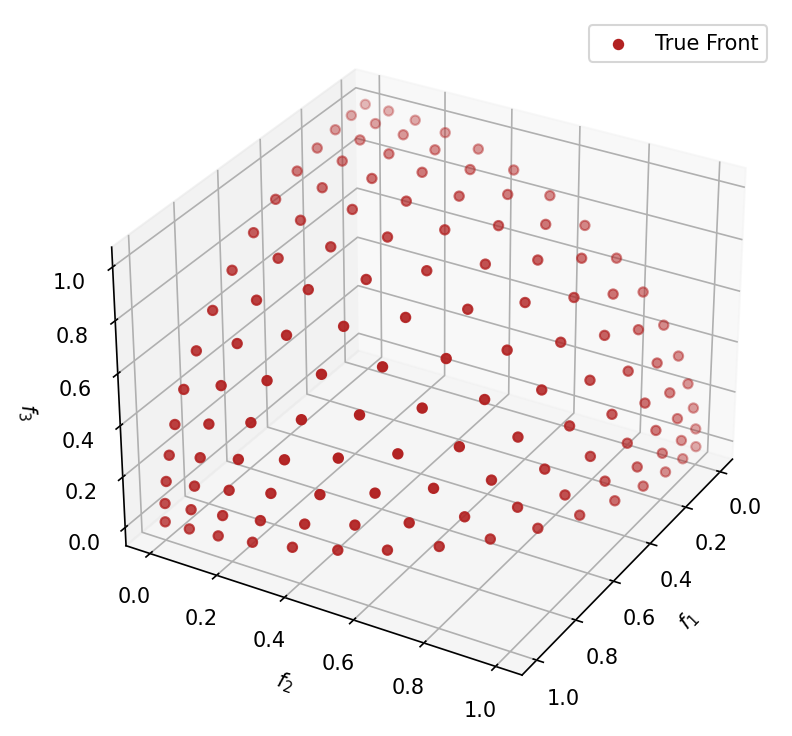

In [3]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})
ax.scatter(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1], problem.pareto_front()[:, 2],
        color="firebrick", label="True Front", marker="o")

ax.view_init(elev=30, azim=30)

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()

In [4]:
NGEN = 250
POPSIZE = 136
SEED = 3

In [5]:
problem.__dict__

{'k': 8,
 'n_var': 10,
 'n_obj': 3,
 'n_constr': 0,
 'data': {'type_var': numpy.float64},
 'xl': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'xu': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'callback': None,
 'check_inconsistencies': True,
 'replace_nan_values_by': inf,
 'exclude_from_serialization': [],
 '_pareto_set': <pymoo.util.cache.Cache at 0x228097b1f10>,
 '_pareto_front': <pymoo.util.cache.Cache at 0x228097b1eb0>,
 '_ideal_point': None,
 '_nadir_point': None}

In [6]:
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=15)

In [7]:
ref_dirs.shape

(136, 3)

In [8]:
gde3 = GDE3(pop_size=POPSIZE, variant="DE/rand/1/bin", CR=0.2, F=(0.0, 1.0), gamma=1e-4,
            survival=RankSurvival(crowding_func="mnn"))

res_gde3 = minimize(problem,
                        gde3,
                        ('n_gen', NGEN),
                         seed=SEED,
                         save_history=True,
                         verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  0.409543711 |  0.501275985
    2 |     272 |  0.369005108 |  0.487152048
    3 |     408 |  0.322285961 |  0.427555045
    4 |     544 |  0.307308801 |  0.376874730
    5 |     680 |  0.267143518 |  0.354490418
    6 |     816 |  0.256532066 |  0.343979295
    7 |     952 |  0.225434431 |  0.281456735
    8 |    1088 |  0.203292026 |  0.255757701
    9 |    1224 |  0.178976836 |  0.228858687
   10 |    1360 |  0.173607528 |  0.217131770
   11 |    1496 |  0.157924808 |  0.199809528
   12 |    1632 |  0.146930391 |  0.181784639
   13 |    1768 |  0.137704510 |  0.156877308
   14 |    1904 |  0.126519866 |  0.144242029
   15 |    2040 |  0.119242898 |  0.134042231
   16 |    2176 |  0.110318913 |  0.122503651
   17 |    2312 |  0.101503636 |  0.115160399
   18 |    2448 |  0.095498280 |  0.103646021
   19 |    2584 |  0.091130858 |  0.099989369
   20 |    2720 |  0.084462722 |  0.086172653
   21 |    2856 |  0.079840610 |  

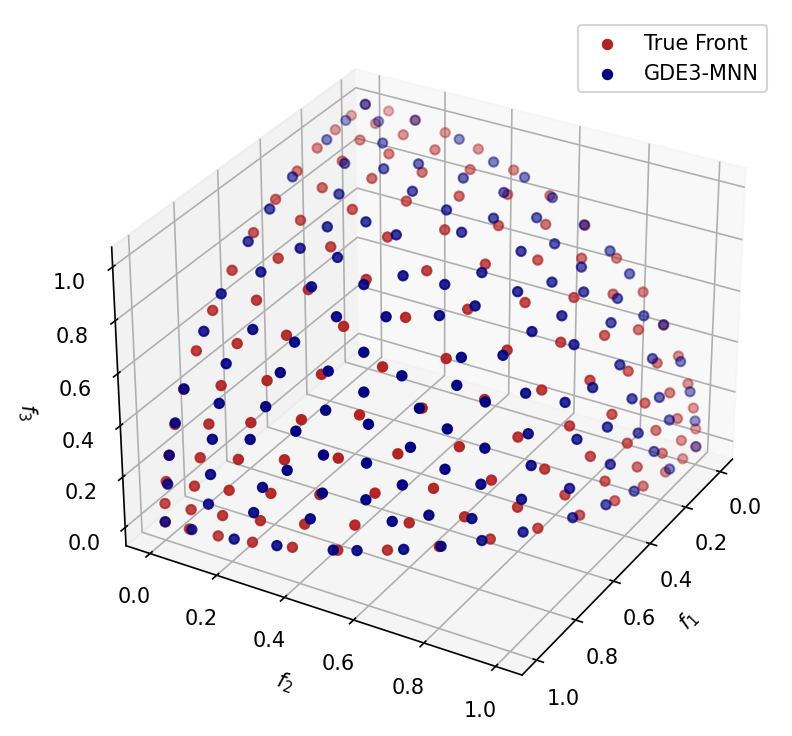

In [9]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})

ax.scatter(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1], problem.pareto_front()[:, 2],
        color="firebrick", label="True Front", marker="o")

ax.scatter(res_gde3.F[:, 0], res_gde3.F[:, 1], res_gde3.F[:, 2],
        color="navy", label="GDE3-MNN", marker="o")

ax.view_init(elev=30, azim=30)

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()

In [10]:
nsga3 = NSGA3(pop_size=POPSIZE, ref_dirs=ref_dirs)

res_nsga3 = minimize(problem,
                     nsga3,
                     ('n_gen', NGEN),
                     seed=SEED,
                     save_history=True,
                     verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  0.393674217 |  0.446761025
    2 |     272 |  0.402516910 |  0.419809947
    3 |     408 |  0.332838890 |  0.399723995
    4 |     544 |  0.341881392 |  0.353695259
    5 |     680 |  0.307222462 |  0.308094079
    6 |     816 |  0.243138514 |  0.282244357
    7 |     952 |  0.218084895 |  0.229831199
    8 |    1088 |  0.195276182 |  0.186005118
    9 |    1224 |  0.184237542 |  0.179413619
   10 |    1360 |  0.154592323 |  0.147852330
   11 |    1496 |  0.141378497 |  0.117015978
   12 |    1632 |  0.128088053 |  0.108300983
   13 |    1768 |  0.117127790 |  0.102611385
   14 |    1904 |  0.109063790 |  0.092386546
   15 |    2040 |  0.102160464 |  0.092971160
   16 |    2176 |  0.094986874 |  0.084390123
   17 |    2312 |  0.087888195 |  0.080145166
   18 |    2448 |  0.084211524 |  0.076998628
   19 |    2584 |  0.079625327 |  0.073335632
   20 |    2720 |  0.077719570 |  0.071362009
   21 |    2856 |  0.072934003 |  

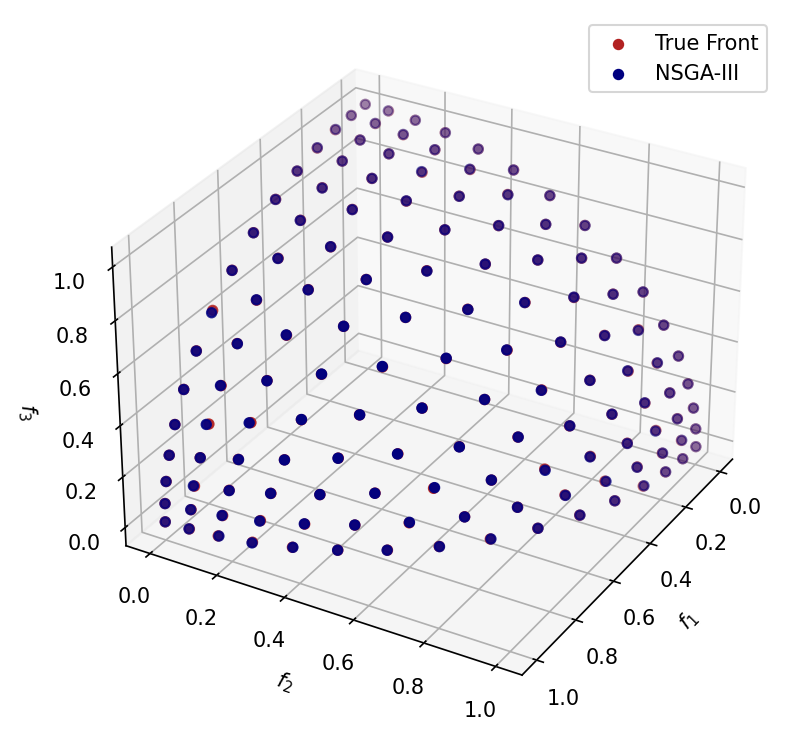

In [11]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})

ax.scatter(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1], problem.pareto_front()[:, 2],
        color="firebrick", label="True Front", marker="o")

ax.scatter(res_nsga3.F[:, 0], res_nsga3.F[:, 1], res_nsga3.F[:, 2],
        color="navy", label="NSGA-III", marker="o")

ax.view_init(elev=30, azim=30)

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()

In [12]:
nsder = NSDER(ref_dirs=ref_dirs, pop_size=POPSIZE, variant="DE/rand/1/bin", CR=0.5, F=(0.0, 1.0), gamma=1e-4)
    
res_nsder = minimize(problem,
                     nsder,
                     ('n_gen', NGEN),
                     seed=SEED,
                     save_history=True,
                     verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  0.409543711 |  0.488790248
    2 |     272 |  0.396262436 |  0.516014751
    3 |     408 |  0.313959571 |  0.459868987
    4 |     544 |  0.278391598 |  0.377125603
    5 |     680 |  0.254458187 |  0.319947642
    6 |     816 |  0.251649791 |  0.318059820
    7 |     952 |  0.202185934 |  0.277925095
    8 |    1088 |  0.199974830 |  0.233034380
    9 |    1224 |  0.187967349 |  0.218655891
   10 |    1360 |  0.171235785 |  0.168226582
   11 |    1496 |  0.175469822 |  0.156416577
   12 |    1632 |  0.140233577 |  0.149915770
   13 |    1768 |  0.134621046 |  0.139799071
   14 |    1904 |  0.115679133 |  0.120596261
   15 |    2040 |  0.104550372 |  0.102670226
   16 |    2176 |  0.095206436 |  0.090891889
   17 |    2312 |  0.087485535 |  0.082753040
   18 |    2448 |  0.085110447 |  0.079300138
   19 |    2584 |  0.080738305 |  0.073952049
   20 |    2720 |  0.076044016 |  0.071317665
   21 |    2856 |  0.071184652 |  

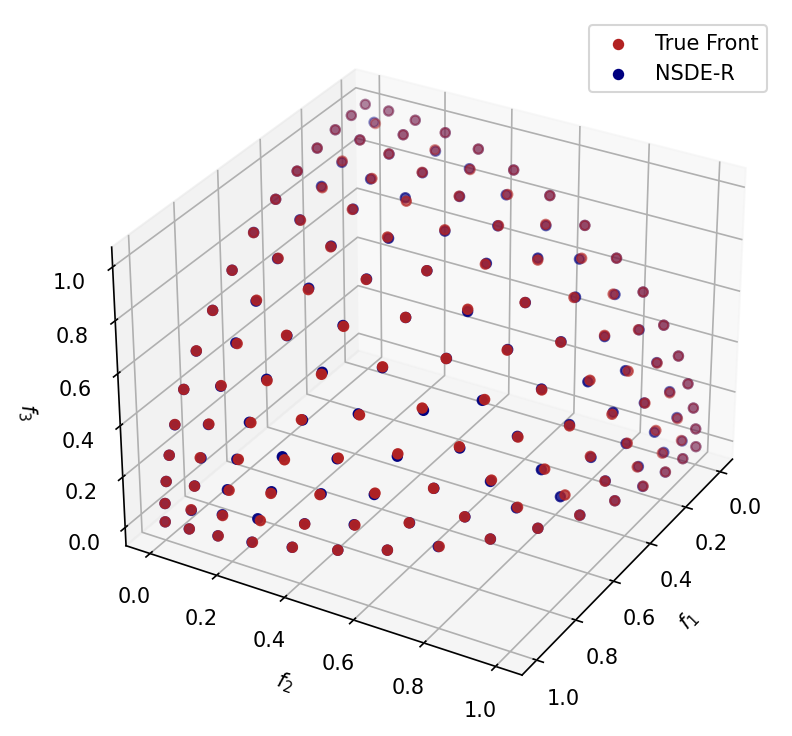

In [13]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})

ax.scatter(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1], problem.pareto_front()[:, 2],
        color="firebrick", label="True Front", marker="o")

ax.scatter(res_nsder.F[:, 0], res_nsder.F[:, 1], res_nsder.F[:, 2],
        color="navy", label="NSDE-R", marker="o")

ax.view_init(elev=30, azim=30)

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()